# Project description

**Forecasting taxi orders**

The company "Precisely Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak periods, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the RMSE metric on the test set should not exceed 48.

# Table of contents

---

1. [Data](#data)
    * [Conclusion](#data-conclusion)
2. [Analysis](#analysis)
    * [Conclusion](#analysis-conclusion)
3. [Model preparation](#model-preparation)
    * [Datasets](#model-datasets-preparation)
    * [Hyperparameter tuning](#model-hyperparameter-tuning)
    * [Conclusion](#model-conclusion)
4. [Model training](#model-training)
5. [Model testing](#model-testing)
6. [Conclusion](#conclusion)
---

## Data <a class="anchor" id="data"></a>

In [1]:
%%capture
!pip install catboost

In [2]:
import datetime
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor


In [3]:
# Searching for file
file_names = ['taxi.csv']
url = 'https://code.s3.yandex.net/datasets/taxi.csv'

file_path = None

for root, dirs, files in os.walk('.'):
    for file_name in file_names:
        if file_name in files:
            file_path = os.path.join(root, file_name)
            break
    else:
        continue
    break

if file_path is not None:
    df = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv(url, index_col=[0], parse_dates=[0])

# Ignoring all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Basic information
print(f"Shape of dataframe: {df.shape}")
print(f"-" * 26)
print(f"Missing values: \n")
print(df.isnull().sum().sum())
print(f"-" * 26)
print(f"Duplicates: {df.duplicated().sum() / len(df) * 100}%")
print(f"-" * 26)
print(f"Dataframe info: \n")
print(df.info())
print(f"-" * 26)
print(f"\nChecking for chronological order: {df.index.is_monotonic}")
display(df.head())
print(f"\n")
display(df.describe())
print(f"\n")

Shape of dataframe: (26496, 1)
--------------------------
Missing values: 

0
--------------------------
Duplicates: 99.69429347826086%
--------------------------
Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
--------------------------

Checking for chronological order: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
df = df.resample('1H').sum()
print(f"Missing values after resampling: {df.isna().mean().to_string(index=False)}")
print(f"-" * 26)
print(f"Range of dates: {df.index.date.min()} - {df.index.date.max()}")
print(f"-" * 26)
print(f"Number of days available for analysis: {(df.index.max()-df.index.min()).days}")
print(f"-" * 26)
df.sort_values(by='num_orders', ascending=False).head()

Missing values after resampling: 0.0
--------------------------
Range of dates: 2018-03-01 - 2018-08-31
--------------------------
Number of days available for analysis: 183
--------------------------


,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295


### Conclusion <a class="anchor" id="data-conclusion"></a>

- When opening the dataframe, the date column was replaced with the index.
- We obtained the size of the array and saw basic information about it.
- No anomalies were found in the data.
- The data is available for 183 days (6 months).
- Preprocessing and EDA are not necessary as the data is clean and correct.
- We performed resampling to one hour, as specified in the brief.

## Analysis <a class="anchor" id="analysis"></a>

Let's decompose the data into trend, seasonality, and residuals using the `seasonal_decompose()` function from the `tsa.seasonal` module. To do this, we will plot graphs for Trend, Seasonality, and Residuals respectively for all data.

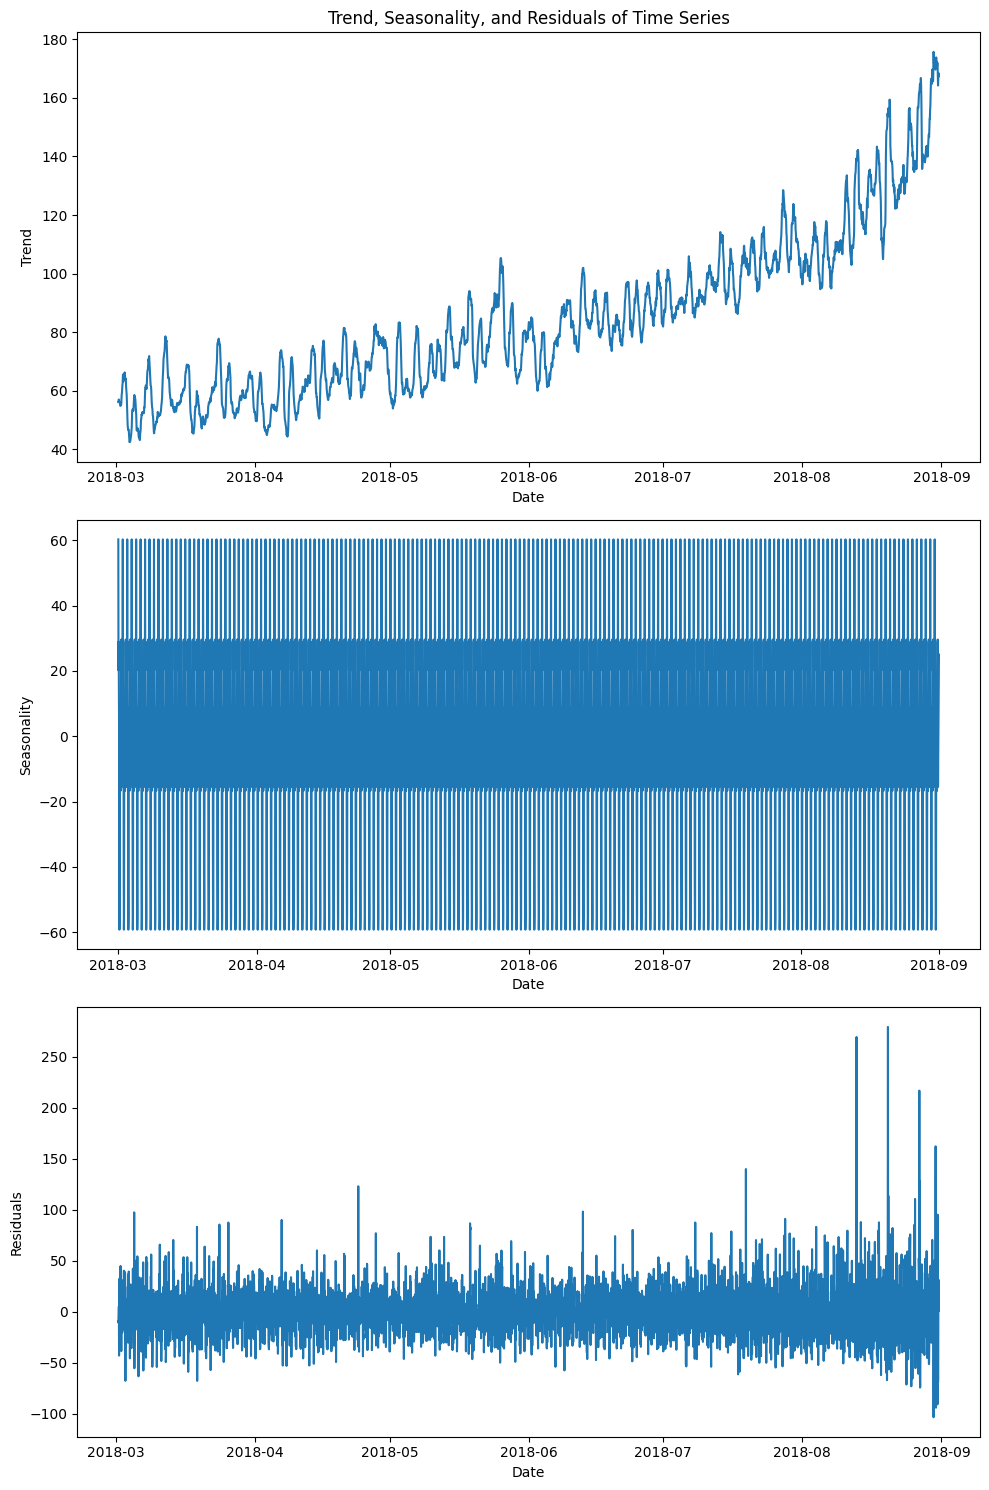

In [5]:
decomposed = seasonal_decompose(df)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

axes[0].plot(decomposed.trend.index, decomposed.trend.values)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Trend')
axes[0].set_title('Trend, Seasonality, and Residuals of Time Series')

axes[1].plot(decomposed.seasonal.index, decomposed.seasonal.values)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Seasonality')
axes[1].set_title('')

axes[2].plot(decomposed.resid.index, decomposed.resid.values)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title('')

plt.tight_layout()
plt.show()

Distribution for the last week.

In [6]:
# Variables for the start and end of the last week:
lastweek_end = df.index.max()
lastweek_start = [lastweek_end - datetime.timedelta(days=x) for x in range(7)]
lastweek_start = lastweek_start[-1].strftime('%Y-%m-%d')

# Define the day of the week
y, m, d = (int(x) for x in lastweek_start.split('-'))
weekday = datetime.date(y, m, d)
print(f"Weekday: {weekday.strftime('%A')}")

Weekday: Saturday


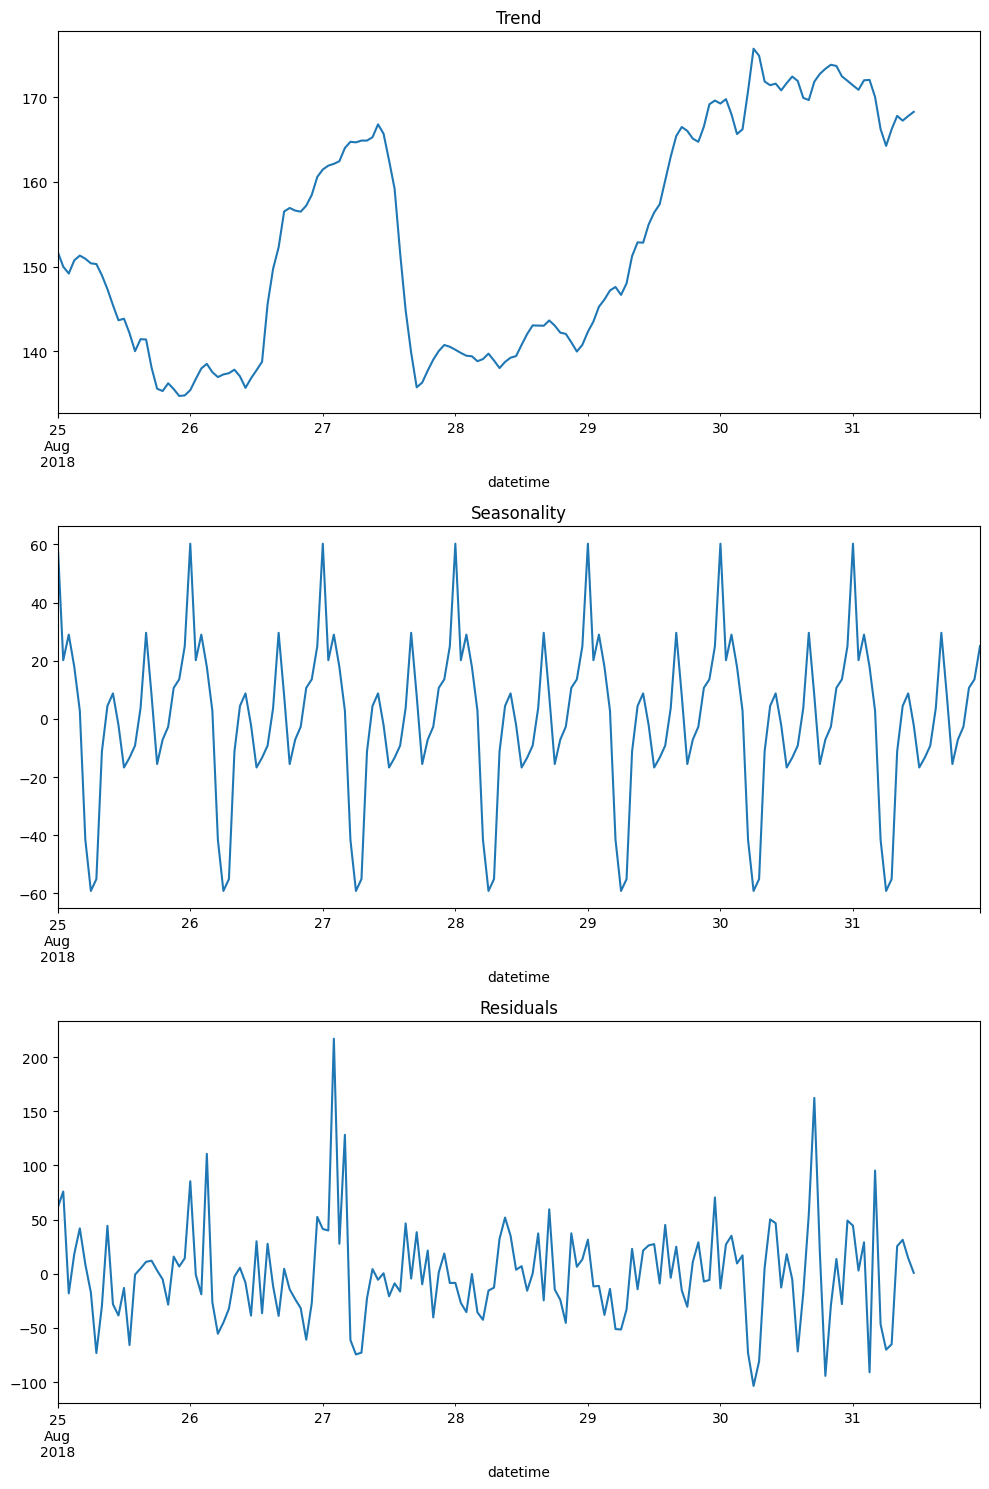

In [7]:
# Plot last week's trend, seasonality, and residuals
fig, axs = plt.subplots(nrows=3, figsize=(10, 15))

decomposed.trend.loc[lastweek_start:lastweek_end].plot(ax=axs[0])
axs[0].set_title('Trend')
decomposed.seasonal.loc[lastweek_start:lastweek_end].plot(ax=axs[1])
axs[1].set_title('Seasonality')
decomposed.resid.loc[lastweek_start:lastweek_end].plot(ax=axs[2])
axs[2].set_title('Residuals')

plt.tight_layout()
plt.show()

Moving standard deviation.

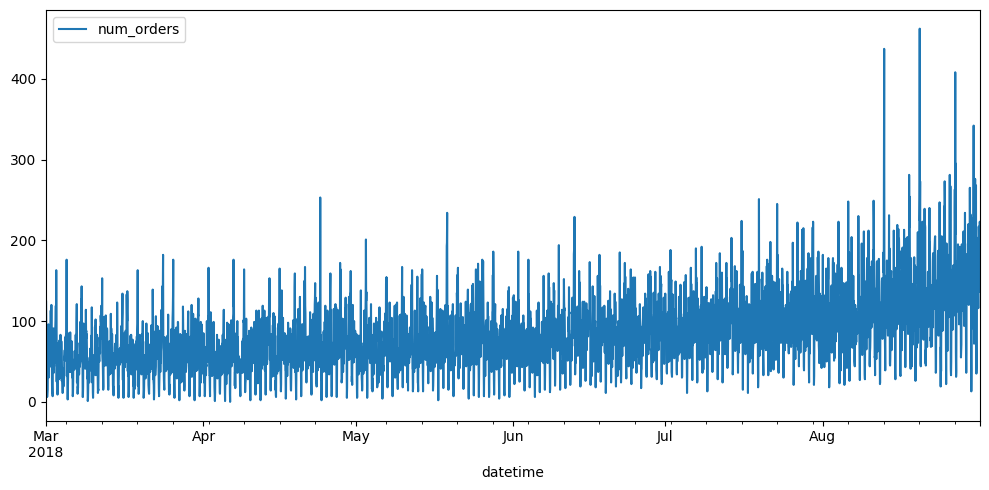

In [8]:
df_shifted = df - df.shift()

df_shifted['mean'] = df['num_orders'].rolling(9).mean()
df_shifted['std'] = df['num_orders'].rolling(9).std()
df.plot(figsize=(10, 5))
plt.tight_layout()
plt.show()

### Conclusion <a class="anchor" id="analysis-conclusion"></a>

- There is an upward trend in the number of taxi orders during the specified period.
- In the context of the last week, there is an increased demand for taxis on **Mondays** and during **Thursday to Saturday** period.

## Model preparation <a class="anchor" id="model-preparation"></a>

### Datasets <a class="anchor" id="model-datasets-preparation"></a>

We need to prepare calendar features using a custom function called `make_features`.

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)   
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Let's conduct an augmented Dickey-Fuller test with the following hypotheses:

- H<sub>0</sub>: The time series is non-stationary.
- H<sub>1</sub>: The time series is stationary.

In [10]:
result = adfuller(df, autolag='AIC')
print(f"ADF: {result[0]}%")
print(f"P-value: {result[1]}%")
print(f"Critical values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Null hypothesis is rejected, it means the time series is stationary")
    else:
        print ("Null hypothesis is not rejected, it means the time series is non-stationary")

ADF: -3.0689242890279504%
P-value: 0.028940051402613316%
Critical values:
	1%: -3.432
Null hypothesis is rejected, it means the time series is stationary
	5%: -2.862
Null hypothesis is rejected, it means the time series is stationary
	10%: -2.567
Null hypothesis is rejected, it means the time series is stationary


In [11]:
make_features(df, 12, 20)
df.head(7)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Datasets split
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test = test['num_orders']

# Check the datasets size
x = df.shape[0]
a = train.shape[0]
b = test.shape[0]

def perc(pt, whl):
    return round(100 * pt / whl)

print(f"Original data: {x}")
print(f"Train dataset: {perc(a, x)}%, shape: {train.shape}")
print(f"Test dataset: {perc(b, x)}%, shape: {test.shape}")

Original data: 4416
Train dataset: 90%, shape: (3954, 16)
Test dataset: 10%, shape: (442, 16)


### Hyperparameter tuning <a class="anchor" id="model-hyperparameter-tuning"></a>

The following models will be used:
- DecisionTreeRegressor
- LinearRegression
- CatBoostRegressor
- LGBMRegressor

We will determine the best hyperparameters using `RandomizedSearchCV`, with the help of `TimeSeriesSplit`.

In [13]:
state = 8080

tscv = TimeSeriesSplit(n_splits=4)

In [14]:
# Passing hyperparameters:
def grid_search(clf_name):
    params = {'DecisionTreeRegressor'   : {'max_depth'        : range(1, 100, 1),
                                           'max_features'     : ['auto'],
                                           'min_samples_leaf' : range(1, 100, 1),
                                           'criterion'        : ['squared_error']},
             'CatBoostRegressor'        : {'loss_function'    : ['RMSE'],
                                           'depth'            : range(1, 10, 1),
                                           'learning_rate'    : [0.01, 0.05, 0.1],
                                           'iterations'       : [200, 400, 800],
                                           'l2_leaf_reg'      : range(2, 30, 1)},
             'LGBMRegressor'            : {'max_depth'        : range(40, 150, 1),
                                           'num_leaves'       : range(1, 100, 1),
                                           'n_estimators'     : range(100, 1000, 100),
                                           'learning_rate'    : [0.01, 0.1, 0.2]}
             }
    return params[clf_name]

**DecisionTreeRegressor**

In [15]:
%%time

model_dtr = DecisionTreeRegressor()

model_dtr = DecisionTreeRegressor(random_state=state)
grid_dtr = RandomizedSearchCV(
    model_dtr,
    grid_search(clf_name=type(model_dtr).__name__),
    scoring='neg_mean_squared_error', cv=tscv,
    n_jobs=-1
)
grid_dtr.fit(X_train, y_train)

means = grid_dtr.cv_results_['mean_test_score']
model_dtr_rmse = (max(means)*-1) ** 0.5
model_dtr_rmse = round(model_dtr_rmse, 2)

dtr_best_params = grid_dtr.best_params_

print(f"\nBest parameters for {type(model_dtr).__name__}")
print(f"{dtr_best_params}\n")
print(f"RMSE: {model_dtr_rmse}\n")


Best parameters for DecisionTreeRegressor
{'min_samples_leaf': 40, 'max_features': 'auto', 'max_depth': 94, 'criterion': 'squared_error'}

RMSE: 30.81

CPU times: user 215 ms, sys: 79.1 ms, total: 294 ms
Wall time: 3.07 s


**CatBoostRegressor**

In [16]:
%%time

model_cbr = CatBoostRegressor(logging_level='Silent')

grid_cbr = RandomizedSearchCV(
    model_cbr,
    grid_search(clf_name=type(model_cbr).__name__),
    scoring='neg_mean_squared_error', cv=tscv,
    n_jobs=-1, verbose=False
)
grid_cbr.fit(X_train, y_train)

means = grid_cbr.cv_results_['mean_test_score']
model_cbr_rmse = (max(means)*-1) ** 0.5
model_cbr_rmse = round(model_cbr_rmse, 2)

cbr_best_params = grid_cbr.best_params_

print(f"\nBest parameters for {type(model_cbr).__name__}")
print(f"{cbr_best_params}\n")
print(f"RMSE: {model_cbr_rmse}\n")


Best parameters for CatBoostRegressor
{'loss_function': 'RMSE', 'learning_rate': 0.1, 'l2_leaf_reg': 11, 'iterations': 400, 'depth': 5}

RMSE: 25.94

CPU times: user 2.27 s, sys: 150 ms, total: 2.42 s
Wall time: 1min 15s


**LGBMRegressor**

In [17]:
%%time

model_lgbmr = LGBMRegressor()

grid_lgbmr = RandomizedSearchCV(
    model_lgbmr,
    grid_search(clf_name=type(model_lgbmr).__name__),
    scoring='neg_mean_squared_error', cv=tscv,
    n_jobs=-1, verbose=False
)
grid_lgbmr.fit(X_train, y_train)

means = grid_lgbmr.cv_results_['mean_test_score']
model_lgbmr_rmse = (max(means)*-1) ** 0.5
model_lgbmr_rmse = round(model_lgbmr_rmse, 2)

lgbmr_best_params = grid_lgbmr.best_params_

print(f"\nBest parameters for {type(model_lgbmr).__name__}")
print(f"{lgbmr_best_params}\n")
print(f"RMSE: {model_lgbmr_rmse}\n")


Best parameters for LGBMRegressor
{'num_leaves': 19, 'n_estimators': 400, 'max_depth': 109, 'learning_rate': 0.01}

RMSE: 26.04

CPU times: user 2.97 s, sys: 44.5 ms, total: 3.01 s
Wall time: 36.8 s


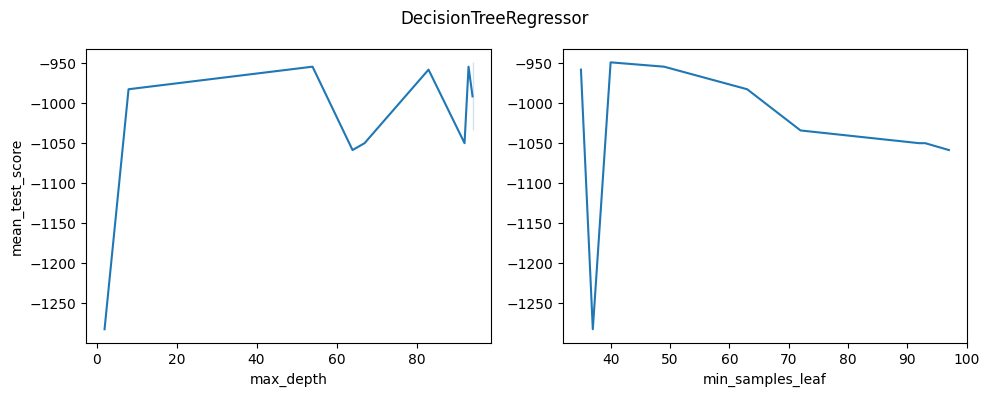

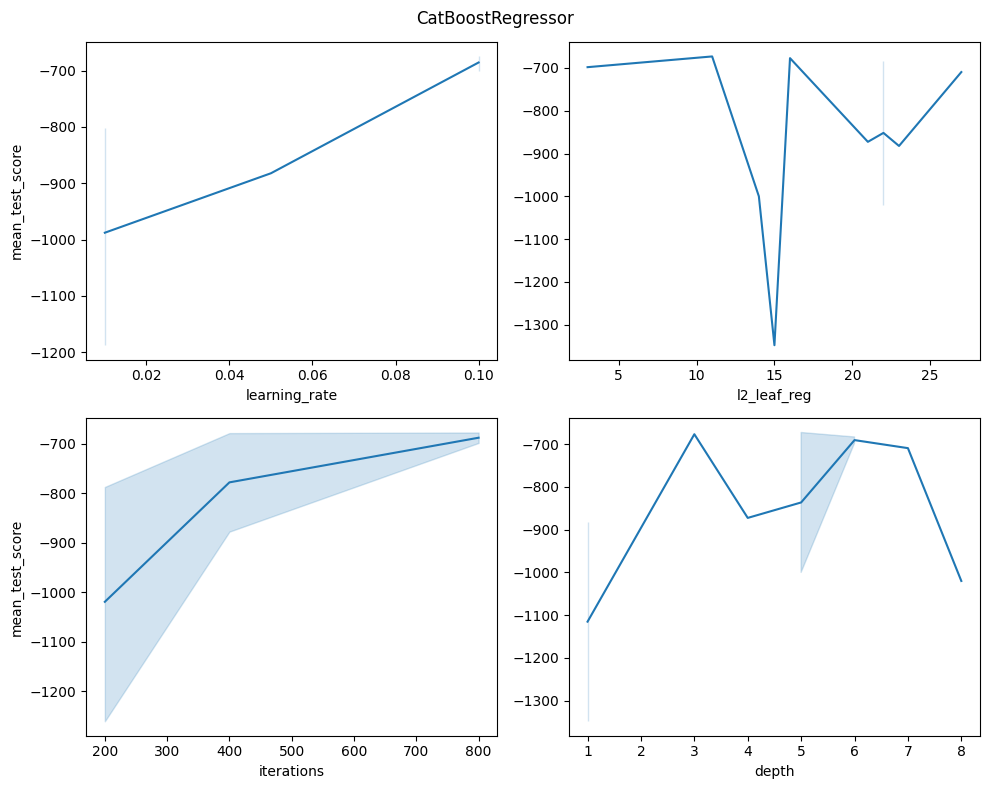

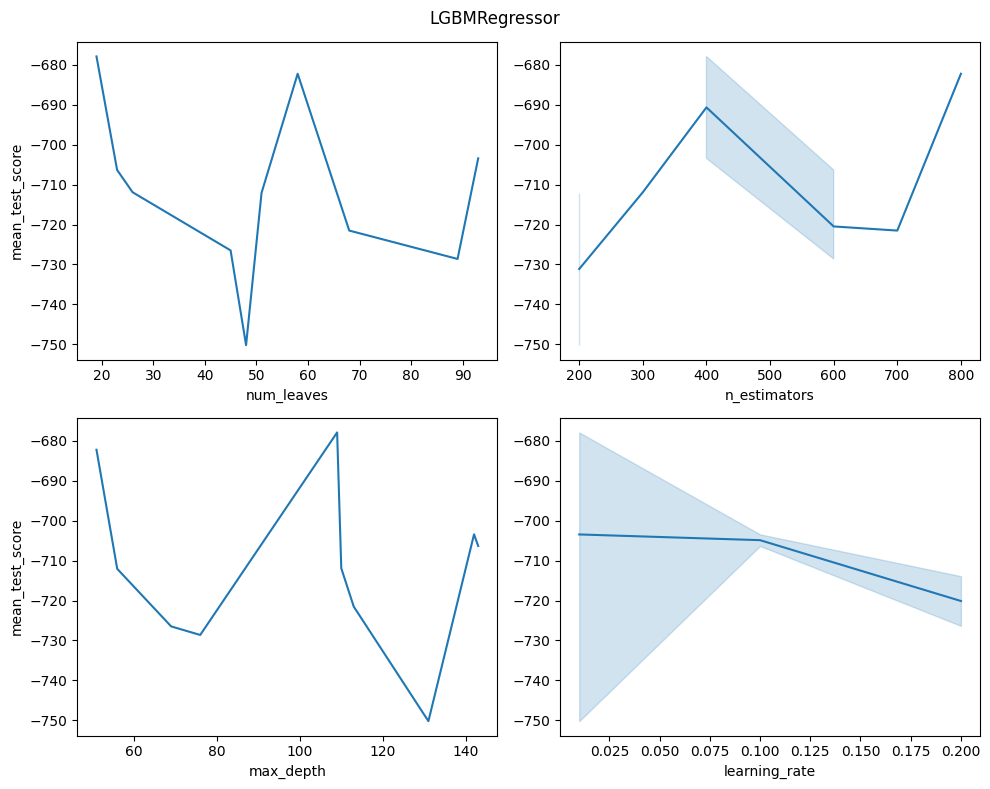

In [18]:
# DecisionTreeRegressor
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.DataFrame(grid_dtr.cv_results_), ax=axs[0])
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=pd.DataFrame(grid_dtr.cv_results_), ax=axs[1])
fig.suptitle('DecisionTreeRegressor')
axs[0].set(xlabel='max_depth', ylabel='mean_test_score')
axs[1].set(xlabel='min_samples_leaf', ylabel='')
plt.tight_layout()

# CatBoostRegressor
fig1, axs1 = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
sns.lineplot(x='param_learning_rate', y='mean_test_score', data=pd.DataFrame(grid_cbr.cv_results_), ax=axs1[0,0])
sns.lineplot(x='param_l2_leaf_reg', y='mean_test_score', data=pd.DataFrame(grid_cbr.cv_results_), ax=axs1[0,1])
sns.lineplot(x='param_iterations', y='mean_test_score', data=pd.DataFrame(grid_cbr.cv_results_), ax=axs1[1,0])
sns.lineplot(x='param_depth', y='mean_test_score', data=pd.DataFrame(grid_cbr.cv_results_), ax=axs1[1,1])
fig1.suptitle('CatBoostRegressor')
axs1[0,0].set(xlabel='learning_rate', ylabel='mean_test_score')
axs1[0,1].set(xlabel='l2_leaf_reg', ylabel='')
axs1[1,0].set(xlabel='iterations', ylabel='mean_test_score')
axs1[1,1].set(xlabel='depth', ylabel='')
plt.tight_layout()

# LGBMRegressor
fig2, axs2 = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
sns.lineplot(x='param_num_leaves', y='mean_test_score', data=pd.DataFrame(grid_lgbmr.cv_results_), ax=axs2[0,0])
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=pd.DataFrame(grid_lgbmr.cv_results_), ax=axs2[0,1])
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.DataFrame(grid_lgbmr.cv_results_), ax=axs2[1,0])
sns.lineplot(x='param_learning_rate', y='mean_test_score', data=pd.DataFrame(grid_lgbmr.cv_results_), ax=axs2[1,1])
fig2.suptitle('LGBMRegressor')
axs2[0,0].set(xlabel='num_leaves', ylabel='mean_test_score')
axs2[0,1].set(xlabel='n_estimators', ylabel='')
axs2[1,0].set(xlabel='max_depth', ylabel='mean_test_score')
axs2[1,1].set(xlabel='learning_rate', ylabel='')

plt.tight_layout()
plt.show()

### Conclusion <a class="anchor" id="model-conclusion"></a>

For each model, we obtained the RMSE value during the parameter tuning process. Let's take a look at them and the best parameters found by `RandomizedSearchCV`:

In [19]:
rmse_vals = {'DTR'  : model_dtr_rmse,
             'CBR'  : model_cbr_rmse,
             'LGBMR': model_lgbmr_rmse
}
rmse_subtotals = pd.DataFrame(rmse_vals, index=[1])
rmse_subtotals

,DTR,CBR,LGBMR
1,30.81,25.94,26.04


In [20]:
params_vals = {'DTR'  : grid_dtr.best_params_,
               'CBR'  : grid_cbr.best_params_,
               'LGBMR': grid_lgbmr.best_params_
}
params_df = pd.DataFrame(params_vals)
params_df.fillna('', inplace=True)
params_df

,DTR,CBR,LGBMR
min_samples_leaf,40,,
max_features,auto,,
max_depth,94,,109.0
criterion,squared_error,,
loss_function,,RMSE,
learning_rate,,0.1,0.01
l2_leaf_reg,,11,
iterations,,400,
depth,,5,
num_leaves,,,19.0


## Model training <a class="anchor" id="model-training"></a>

We will train the models with the parameters selected by `RandomizedSearchCV`.

In [21]:
models = [
    {'name': 'DecisionTreeRegressor', 'model': DecisionTreeRegressor(**dtr_best_params)},
    {'name': 'LinearRegression', 'model': LinearRegression()},
    {'name': 'CatBoostRegressor', 'model': CatBoostRegressor(**cbr_best_params, logging_level='Silent')},
    {'name': 'LGBMRegressor', 'model': LGBMRegressor(**lgbmr_best_params)}
]

rmse_results = []

for model_dict in models:
    model_name = model_dict['name']
    model = model_dict['model']
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    model_rmse = mean_squared_error(y_train, predictions) ** 0.5
    model_rmse = round(model_rmse, 2)
    rmse_results.append({'Model': model_name, 'RMSE': model_rmse})

df_rmse_results = pd.DataFrame(rmse_results)
df_rmse_results.sort_values(by='RMSE', ascending=True)

,Model,RMSE
2,CatBoostRegressor,17.79
3,LGBMRegressor,19.60
0,DecisionTreeRegressor,22.96
1,LinearRegression,30.68


## Model testing <a class="anchor" id="model-testing"></a>

Testing all models to get final RMSE (should be lower than 48).

In [22]:
rmse_results_test = []

for model_dict in models:
    model_name = model_dict['name']
    model = model_dict['model']
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    model_rmse = mean_squared_error(y_test, predictions) ** 0.5
    model_rmse = round(model_rmse, 2)
    rmse_results_test.append({'Model': model_name, 'RMSE': model_rmse})

rmse_results_test = pd.DataFrame(rmse_results_test)
rmse_results_test.sort_values(by='RMSE', ascending=True)

,Model,RMSE
3,LGBMRegressor,45.64
2,CatBoostRegressor,46.69
0,DecisionTreeRegressor,51.81
1,LinearRegression,52.56


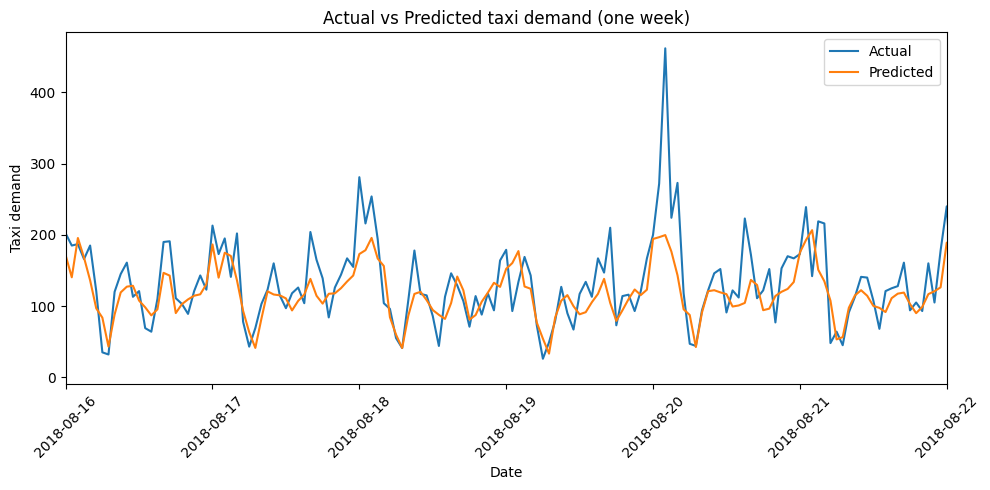

In [23]:
best_model = LGBMRegressor(**lgbmr_best_params)
best_model.fit(X_train, y_train)
best_predictions = best_model.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, best_predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted taxi demand (one week)')
plt.xlabel('Date')
plt.xlim(pd.Timestamp('2018-08-16'), pd.Timestamp('2018-08-22'))
plt.xticks(rotation=45)
plt.ylabel('Taxi demand')

plt.tight_layout()
plt.show()

## Conclusion <a class="anchor" id="conclusion"></a>

During the research, we have:

- replaced the date column with an index;
- obtained the size of the array and basic information about it;
- found no anomalies in the data;
- learned that the data is available for 183 days (6 months);
- resampled the data to one hour as specified in the task brief;
- observed an increasing trend in the number of taxi orders over the given period;
- observed an increased demand for taxis on **Monday** and during **Thursday-Saturday period** over the last week.

For model training:

- prepared samples for analysis in terms of:
    - the proportion of the training sample: 90%
    - the proportion of the test sample: 10%;
- selected four training models: `DecisionTreeRegressor`, `LinearRegression`, `CatBoostRegressor`, and `LGBMRegressor`;
- used `RandomizedSearchCV` with `TimeSeriesSplit` to find the optimal parameters;
- trained the models with the best parameters on train and test samples;
- found the best model which shown the lowest RMSE.